# Mental Health in the Tech Industry - Exploratory Data Analysis

**Aim of the Analysis:** Explore the Mental Health in the Tech Industry dataset to understand how mental health conditions affect professionals working in technology.

## Section 1: Import Libraries

In [1]:
import pandas as pd
import sqlite3
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats

---

## Section 2: Checking Available Tables in the Database

**Goal:** Identify which tables are stored in the SQLite database before proceeding with data exploration and merging.

In [2]:
conn = sqlite3.connect("../data/mental_health.sqlite")
pd.read_sql("SELECT name FROM sqlite_master WHERE type='table';", conn)

,name
0,Answer
1,Question
2,Survey


### **Section 2: Checking Available Tables in the Database**

**Takeaway:** The database contains three tables. <u>Answer</u>, <u>Question</u> and <u>Survey</u>.

---

## Section 3: Exploring Table Structures

**Goal:** Inspect the structure of each table in the SQLite database, identify the available fields and understand how these tables can be connected for analysis.

In [3]:
pd.read_sql("PRAGMA table_info(survey);", conn)

,cid,name,type,notnull,dflt_value,pk
0,0,SurveyID,INTEGER,1,None,1
1,1,Description,VARCHAR(255),0,None,0


In [4]:
pd.read_sql("PRAGMA table_info(Question);", conn)

,cid,name,type,notnull,dflt_value,pk
0,0,questiontext,VARCHAR(1000),0,None,0
1,1,questionid,INTEGER,0,None,0


In [5]:
pd.read_sql("PRAGMA table_info(Answer);", conn)

,cid,name,type,notnull,dflt_value,pk
0,0,AnswerText,VARCHAR(10000),0,None,0
1,1,SurveyID,INTEGER,0,None,0
2,2,UserID,INTEGER,0,None,0
3,3,QuestionID,INTEGER,0,None,0


### **Section 3: Exploring Table Structures**

**Takeaway:** Each table form the core structure of the dataset, where <u>Answer</u> holds user responses, <u>Question</u> defines the survey questions and <u>Survey</u> provides general survey descriptions.

---

## Section 4: Querying and Loading the Final Dataset

**Goal:** To combine the Answer, Question, and Survey tables into a single, unified dataset by using SQL joins.

In [6]:
query = """
SELECT 
    a.UserID,
    s.Description AS SurveyDescription,
    q.QuestionText,
    a.AnswerText
FROM Answer a
JOIN Survey s ON a.SurveyID = s.SurveyID
JOIN Question q ON a.QuestionID = q.QuestionID;
"""
df = pd.read_sql(query, conn)
conn.close()

df.head()

,UserID,SurveyDescription,questiontext,AnswerText
0,1,mental health survey for 2014,What is your age?,37
1,2,mental health survey for 2014,What is your age?,44
2,3,mental health survey for 2014,What is your age?,32
3,4,mental health survey for 2014,What is your age?,31
4,5,mental health survey for 2014,What is your age?,31


### **Section 4: Querying and Loading the Final Dataset**

**Takeaway:** The SQL query successfully <u>merged all three tables</u> into one comprehensive dataframe (df). Each record now contains the respondent ID, survey description, question text and corresponding answer. Dataset ready for exploratory analysis.

---

## Section 5: Overview of Respondents

**Goal:** To provide an overview of the survey respondents by analyzing key sociodemographic factors, such as age, gender, country, state and employment type. This section aims to understand who participated in the survey and to identify any potential sampling biases that may influence the interpretation of the results.

### 5.1 What is the sample size?

**Goal:** Determine the total number of unique respondents who participated in the survey.

In [7]:
sample_size = df['UserID'].nunique()
print("Sample size (number of respondents):", sample_size)

Sample size (number of respondents): 4218


### **Section 5.1: What is the sample size?**

**Takeaway:** The dataset includes 4,218 unique respondents.

---

### 5.2 What are the sociodemographic features of the respondents?

**Goal:** Identify and analyze the key sociodemographic variables captured in the survey.

In [8]:
df[df['questiontext'].str.contains("age|gender|country|state|work", case=False, na=False)]['questiontext'].unique()

array(['What is your age?', 'What is your gender?',
       'What country do you live in?',
       'If you live in the United States, which state or territory do you live in?',
       'Does your employer provide mental health benefits as part of healthcare coverage?',
       'Is your anonymity protected if you choose to take advantage of mental health or substance abuse treatment resources provided by your employer?',
       'If you have a mental health condition, do you feel that it interferes with your work?',
       'Do you work remotely (outside of an office) at least 50% of the time?',
       'Would you be willing to discuss a mental health issue with your coworkers?',
       'Have you heard of or observed negative consequences for coworkers with mental health conditions in your workplace?',
       'Do you know the options for mental health care available under your employer-provided health coverage?',
       'If a mental health issue prompted you to request a medical leave from wo

#### 5.2.1 Age

**Goal:** Analyze the age distribution of respondents and identify the predominant age group participating in the mental health survey within the tech industry.

Age statistics:
count     4204.0
unique      55.0
top         30.0
freq       250.0
Name: AnswerText, dtype: float64


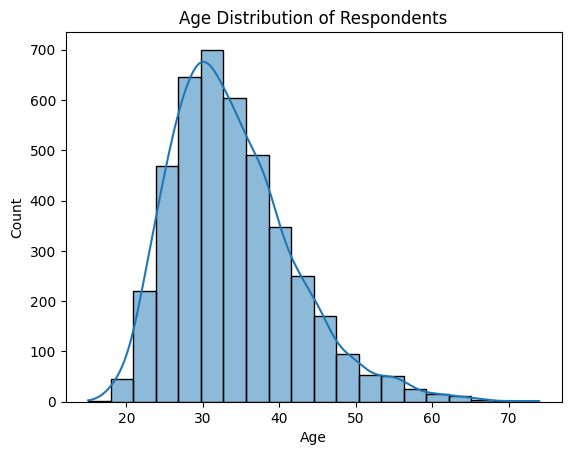

In [9]:
age_df = df[df['questiontext'].str.contains('age', case=False, na=False)].copy()
age_df.loc[:, 'AnswerText'] = pd.to_numeric(age_df['AnswerText'], errors='coerce')
age_df = age_df.dropna(subset=['AnswerText'])
age_df = age_df[(age_df['AnswerText'] >= 15) & (age_df['AnswerText'] <= 80)]

print("Age statistics:")
print(age_df['AnswerText'].describe())

sns.histplot(age_df['AnswerText'], bins=20, kde=True)
plt.title('Age Distribution of Respondents')
plt.xlabel('Age')
plt.ylabel('Count')
plt.show()

#### **5.2.1: Age**

**Takeaway:** Majority of respondents are between 25 and 35 years old. Average age around 30. This suggests that the dataset primarily represents early to mid career professionals in the tech industry.

---

#### 5.2.2 Gender

**Goal:** Analyze the gender composition of respondents in the mental health survey and identify the representation of different gender identities within the tech industry.

Category
Male                           3060
Female                         1048
Other / Invalid                  58
Non-binary / Gender diverse      46
Transgender                       6
Name: count, dtype: int64


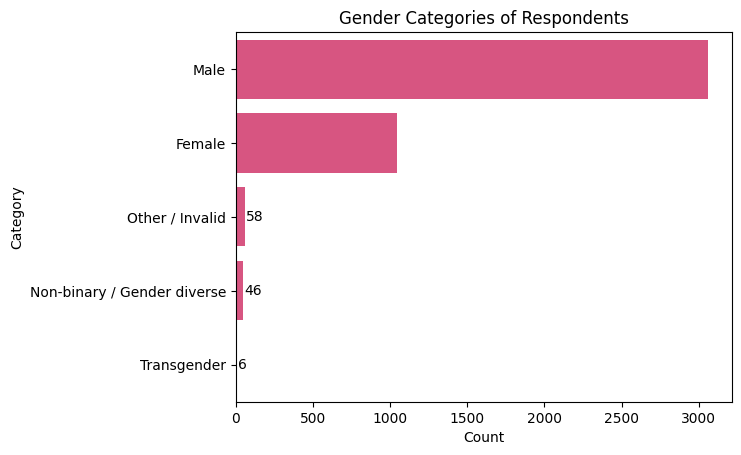

In [10]:
gender_df = df[df['questiontext'].str.contains('gender', case=False, na=False)].copy()
gender_df['AnswerText'] = gender_df['AnswerText'].str.lower().str.strip()

def categorize_gender(v):
    if not isinstance(v, str):
        return 'Other / Invalid'
    if any(k in v for k in ['female', 'woman', 'femme', 'girl']):
        return 'Female'
    if any(k in v for k in ['male', 'man', 'masculino', 'guy']):
        return 'Male'
    if any(k in v for k in ['trans', 'mtf', 'ftm']):
        return 'Transgender'
    if any(k in v for k in ['nonbinary', 'non-binary', 'enby', 'agender',
                            'genderfluid', 'genderqueer', 'androgyn', 'bigender', 'fluid', 'nb']):
        return 'Non-binary / Gender diverse'
    return 'Other / Invalid'

gender_df['Category'] = gender_df['AnswerText'].map(categorize_gender)
gender_counts = gender_df['Category'].value_counts()

print(gender_counts)

ax = sns.barplot(x=gender_counts.values, y=gender_counts.index, color='#EC407A')
plt.title('Gender Categories of Respondents')
plt.xlabel('Count')
plt.ylabel('Category')

for i, (cat, val) in enumerate(zip(gender_counts.index, gender_counts.values)):
    if cat not in ['Male', 'Female']:
        ax.text(val + 10, i, str(val), color='black', va='center')

plt.show()

#### **5.2.2: Gender**

**Takeaway:** The dataset shows a significant gender imbalance. Male respondents (3060) making up the majority, followed by female respondents (1048). Small number of participants identify as non-binary, transgender.
This suggests that men are overrepresented in the dataset, reflecting the broader gender disparity in the tech workforce and potentially influencing the generalizability of the mental health findings.

---

#### 5.2.3 Country

**Goal:** Identify the most common countries represented among respondents and assess the global reach of the dataset.

Country
United States     4476
United Kingdom     782
Canada             321
Germany            226
Netherlands        168
Australia          123
India               89
France              85
Ireland             74
Brazil              67
Name: count, dtype: int64


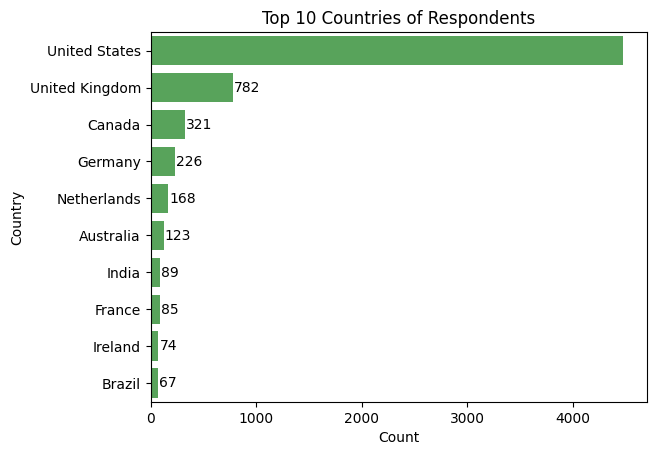

In [11]:
country_df = df[df['questiontext'].str.contains('country', case=False, na=False)].copy()
country_df['AnswerText'] = country_df['AnswerText'].str.strip().str.title()

def normalize_country(name):
    if not isinstance(name, str):
        return 'Other / Invalid'
    n = name.lower()
    if 'united states' in n or 'usa' in n or 'america' in n:
        return 'United States'
    return name

country_df['Country'] = country_df['AnswerText'].map(normalize_country)
country_counts = country_df['Country'].value_counts().head(10)

print(country_counts)

ax = sns.barplot(x=country_counts.values, y=country_counts.index, color='#4CAF50')
plt.title('Top 10 Countries of Respondents')
plt.xlabel('Count')
plt.ylabel('Country')

for i, (name, val) in enumerate(zip(country_counts.index, country_counts.values)):
    if name != 'United States':
        ax.text(val + 10, i, str(val), color='black', va='center')

plt.show()

#### **5.2.3: Country**

**Takeaway:** Vast majority of participants are from the United States, with smaller groups from the United Kingdom, Canada and Germany. This suggests a geographical bias toward English speaking and Western countries. Indicating that results may not fully represent the global workforce’s experiences with mental health in tech.

---

#### 5.2.4 State

**Goal:** Identify which U.S. states are most represented among survey.

AnswerText
California    651
Illinois      420
Washington    264
New York      247
Tennessee     195
Texas         194
Michigan      192
Ohio          187
Minnesota     182
Oregon        163
Name: count, dtype: int64


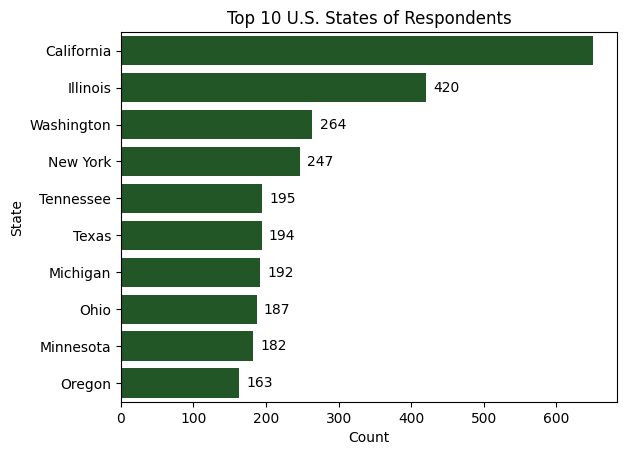

In [12]:
state_df = df[df['questiontext'].str.contains('state', case=False, na=False)].copy()
state_df['AnswerText'] = state_df['AnswerText'].astype(str).str.strip().str.title()
state_df = state_df[~state_df['AnswerText'].isin(['-1', '1', 'Na', 'Nan', 'None', 'Null', '0'])]

state_counts = state_df['AnswerText'].value_counts().head(10)

print(state_counts)

ax = sns.barplot(x=state_counts.values, y=state_counts.index, color='#1B5E20')
plt.title('Top 10 U.S. States of Respondents')
plt.xlabel('Count')
plt.ylabel('State')

for i, (name, val) in enumerate(zip(state_counts.index, state_counts.values)):
    if name != 'California':
        ax.text(val + 10, i, str(val), color='black', va='center')

plt.show()

#### **5.2.4: State**

**Takeaway:** Majority of U.S. participants come from California, followed by Illinois, Washington and New York. These states are home to major technology hubs, indicating that the dataset is heavily influenced by regions with strong tech industry presence.

---

#### 5.2.5 Work

**Goal:** Identify most common work roles among respondents in the tech industry and examine how employment type distribution might influence mental health representation across different professional groups.

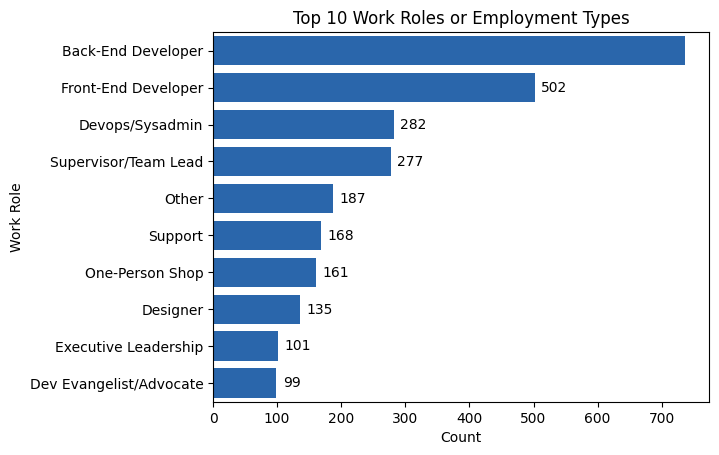

In [13]:
work_df = df[df['questiontext'].str.contains('work position|work type|employment', case=False, na=False)].copy()
work_df['AnswerText'] = work_df['AnswerText'].astype(str).str.strip().str.title()

work_df = work_df[~work_df['AnswerText'].isin(['-1', '1', 'Na', 'Nan', 'None', 'Null', '0', 'United States Of America'])]

work_counts = work_df['AnswerText'].value_counts().head(10)

ax = sns.barplot(x=work_counts.values, y=work_counts.index, color='#1565C0')
plt.title('Top 10 Work Roles or Employment Types')
plt.xlabel('Count')
plt.ylabel('Work Role')

for i, (name, val) in enumerate(zip(work_counts.index, work_counts.values)):
    if name != 'Back-End Developer':
        ax.text(val + 10, i, str(val), color='black', va='center')

plt.show()

#### **5.2.5: Work**

**Takeaway:** Most participants work as Back-End Developers or Front-End Developers, followed by DevOps/Sysadmins and Team Leads. This indicates a strong representation of technical, engineering focused roles within the dataset, while design, support and executive positions are underrepresented. The dominance of developer roles suggests the results may primarily reflect experiences from technical rather than managerial or creative perspectives.

---

### **5.2: What are the sociodemographic features of the respondents?**

**Takeaway:** The sociodemographic analysis reveals that the survey sample is dominated by young, male professionals primarily between the ages of 25 and 35, mostly from the United States and concentrated in major tech oriented states such as California, Illinois and Washington.
Most participants hold technical positions, mainly back-end and front-end development roles.

---

### 5.3 Do you see any evidence of sampling bias?

**Takeaway:**
The dataset exhibits clear sampling bias. The majority of respondents are <u>male</u>, aged between <u>25-35</u>, and primarily located in the <u>United States</u>, particularly in <u>major tech hubs</u> such as <u>California</u> and <u>Washington</u>. Additionally, most participants work in <u>developer</u> or <u>engineering roles</u>, while individuals from non-technical, creative, or leadership positions are <u>underrepresented</u>.
As a result, the findings of this survey are more reflective of young, male, U.S. based developers, limiting the generalizability of conclusions about mental health to the broader global tech workforce.

---

## Section 6: Exploratory Data Analysis

**Goal:** 

### 6.1 Statistical Summaries

**Goal:** To understand the overall structure of the dataset and summarize key characteristics of both numerical and categorical variables.

In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 236898 entries, 0 to 236897
Data columns (total 4 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   UserID             236898 non-null  int64 
 1   SurveyDescription  236898 non-null  object
 2   questiontext       236898 non-null  object
 3   AnswerText         236898 non-null  object
dtypes: int64(1), object(3)
memory usage: 7.2+ MB


**Takeaway:** Dataset contains 236,898 responses across 4 columns. UserID, SurveyDescription, questiontext and AnswerText.

---

In [15]:
df.describe()

,UserID
count,236898.000000
mean,2514.516619
std,1099.462747
min,1.000000
25%,1691.000000
50%,2652.000000
75%,3439.000000
max,4218.000000


**Takeaway:** The only numerical column, UserID, ranges from 1 to 4218, indicating responses from 4,218 unique participants. Since each respondent answered multiple questions, the total of 236,898 entries represents all question/answer combinations rather than distinct individuals.

---

In [16]:
df.isna().sum()

UserID               0
SurveyDescription    0
questiontext         0
AnswerText           0
dtype: int64

**Takeaway:** There are no missing values in any of the columns.

---

### **6.1: Statistical Summaries**

**Takeaway:** The dataset is complete, containing 236,898 total responses from 4,218 unique participants across four columns: UserID, SurveyDescription, questiontext and AnswerText.
All fields are fully populated, meaning no missing values.

### 6.2 Visual Analysis

**Goal:** Visually explore the dataset’s structure by identifying the most common survey descriptions, question types and response frequencies.

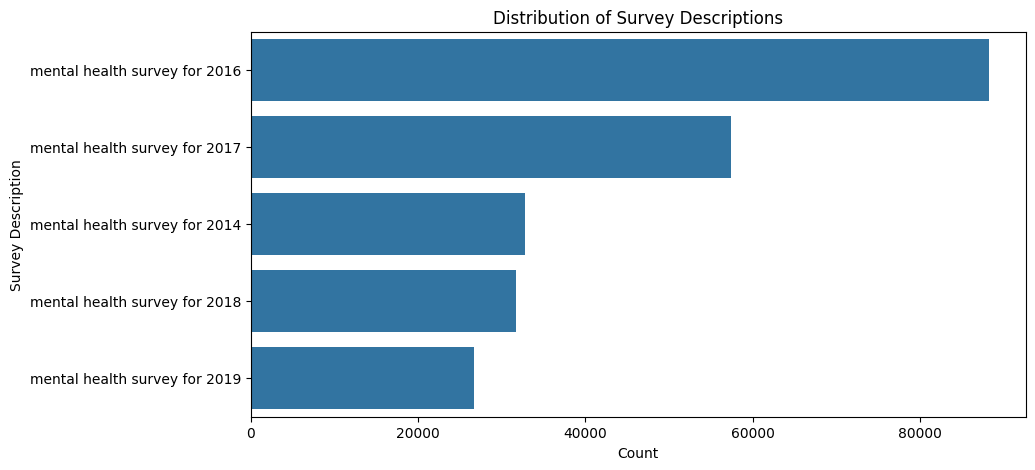

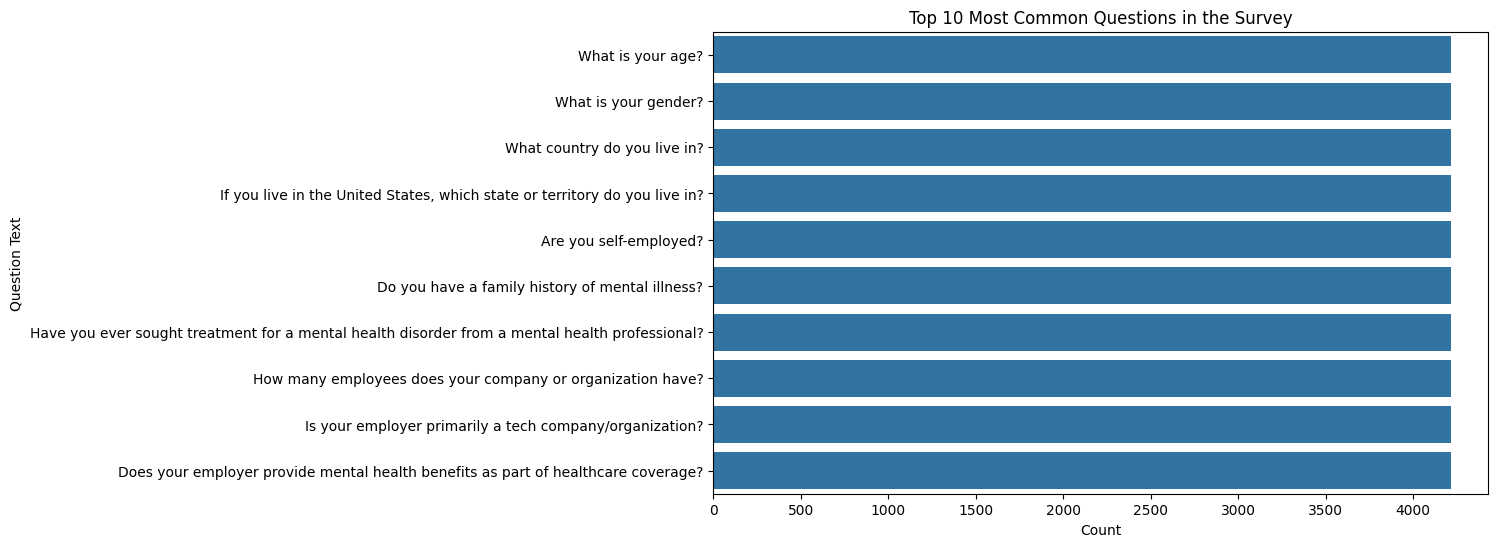

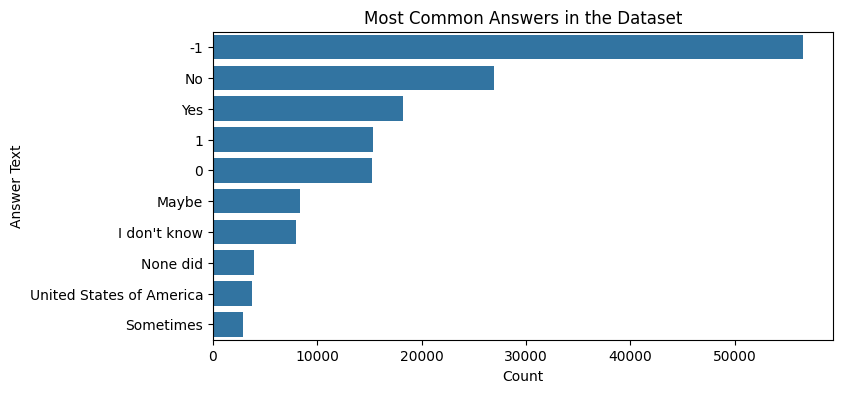

In [17]:
plt.figure(figsize=(10,5))
sns.countplot(y=df['SurveyDescription'], order=df['SurveyDescription'].value_counts().index)
plt.title('Distribution of Survey Descriptions')
plt.xlabel('Count')
plt.ylabel('Survey Description')
plt.show()

plt.figure(figsize=(10,6))
top_questions = df['questiontext'].value_counts().head(10)
sns.barplot(x=top_questions.values, y=top_questions.index)
plt.title('Top 10 Most Common Questions in the Survey')
plt.xlabel('Count')
plt.ylabel('Question Text')
plt.show()

top_answers = df['AnswerText'].value_counts().head(10)
plt.figure(figsize=(8,4))
sns.barplot(x=top_answers.values, y=top_answers.index)
plt.title('Most Common Answers in the Dataset')
plt.xlabel('Count')
plt.ylabel('Answer Text')
plt.show()

### 6.2 Visual Analysis
**Takeaway:**
* Most responses in the dataset come from the 2016 and 2017 surveys, showing these years had the highest participation rates.
* The most common questions focus on demographics (age, gender, location) and mental health background (family history, treatment, workplace support).
* The answer distribution is dominated by simple responses such as “Yes” and “No”, confirming that the majority of survey items are closed ended and well suited for quantitative analysis in the next section.

---

### 6.3 Mental Health Condition Prevalence

**Goal:** Examine how many respondents report having a mental health condition.

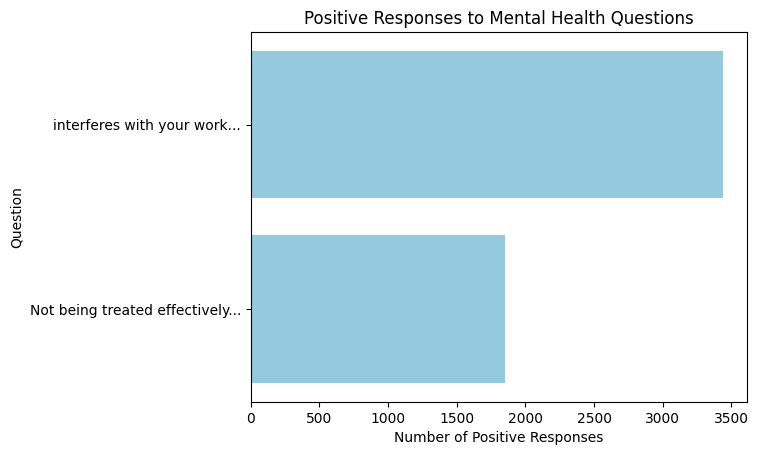

In [18]:
questions = [
    "interferes with your work",
    "Not being treated effectively"
]

positive_words = ["yes", "true", "often", "sometimes"]

results = []
for q in questions:
    subset = df[df["questiontext"].str.contains(q, case=False, na=False)].copy()
    subset["AnswerText"] = subset["AnswerText"].astype(str).str.lower()
    yes_count = subset["AnswerText"].apply(
        lambda x: any(word in x for word in positive_words)
    ).sum()
    results.append({"Question": q[:35] + "...", "Yes Count": yes_count})

plot_df = pd.DataFrame(results)

sns.barplot(data=plot_df, x="Yes Count", y="Question", color="skyblue")
plt.title("Positive Responses to Mental Health Questions")
plt.xlabel("Number of Positive Responses")
plt.ylabel("Question")
plt.show()

### 6.3 Visual Analysis
**Takeaway:** Chart shows most respondents reported rarely or never experiencing a mental health condition, while a smaller but significant portion answered yes or often. Mental health challenges are present within the tech industry, suggesting the need for ongoing awareness and support programs.

---

### 6.4 Mental Health Condition Comparison

**Goal:** How often people answered positively (yes, true, often) to different mental health questions to find which issues are most common among tech workers.

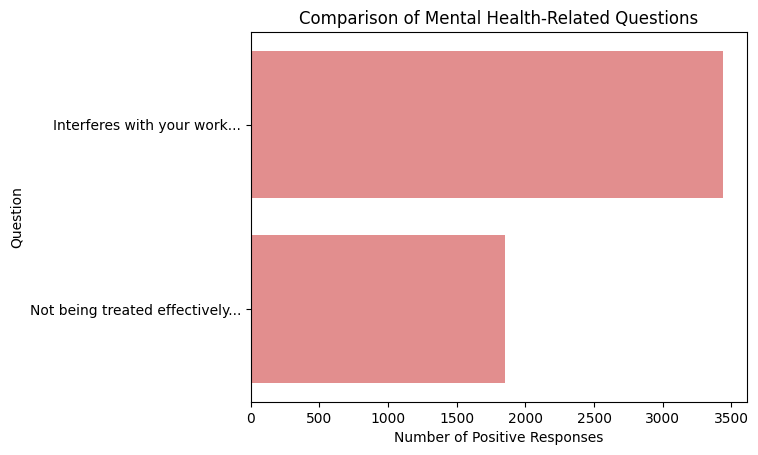

In [19]:
questions = [
    "Interferes with your work",
    "Not being treated effectively"
]

positive_words = ["yes", "true", "often", "sometimes"]

results = []
for q in questions:
    subset = df[df["questiontext"].str.contains(q, case=False, na=False)].copy()
    subset["AnswerText"] = subset["AnswerText"].astype(str).str.lower()
    positive = subset["AnswerText"].apply(
        lambda x: any(word in x for word in positive_words)
    ).sum()
    total = subset["AnswerText"].shape[0]
    results.append({
        "Question": q[:35] + "...",
        "Positive Responses": positive,
        "Total Responses": total
    })

plot_df = pd.DataFrame(results)

sns.barplot(
    data=plot_df,
    x="Positive Responses",
    y="Question",
    color="lightcoral"
)
plt.title("Comparison of Mental Health-Related Questions")
plt.xlabel("Number of Positive Responses")
plt.ylabel("Question")
plt.show()

### 6.4 Mental Health Condition Comparison
**Takeaway:** Most respondents indicated that mental health interferes with their work, while fewer reported problems when not being treated effectively. This suggests that everyday work related stress and mental strain are widely recognized issues in the tech industry, even if not all respondents experience severe or untreated conditions.

---

### 6.5 Confidence Intervals for Mental Health Prevalence

**Goal:** Estimate the prevalence of key mental health conditions and workplace attitudes within the tech industry. To quantify the uncertainty of these estimates using 95% confidence intervals. This provides a statistical understanding of how widespread mental health challenges and perceptions are among respondents.

                                            Question  Prevalence  CI_Lower  \
0  Do you currently have a mental health disorder...       41.82     40.03   
1  If you have a mental health disorder, how ofte...       62.71     60.94   
2  Do you feel that your employer takes mental he...       25.73     24.09   

   CI_Upper  
0     43.62  
1     64.46  
2     27.43  


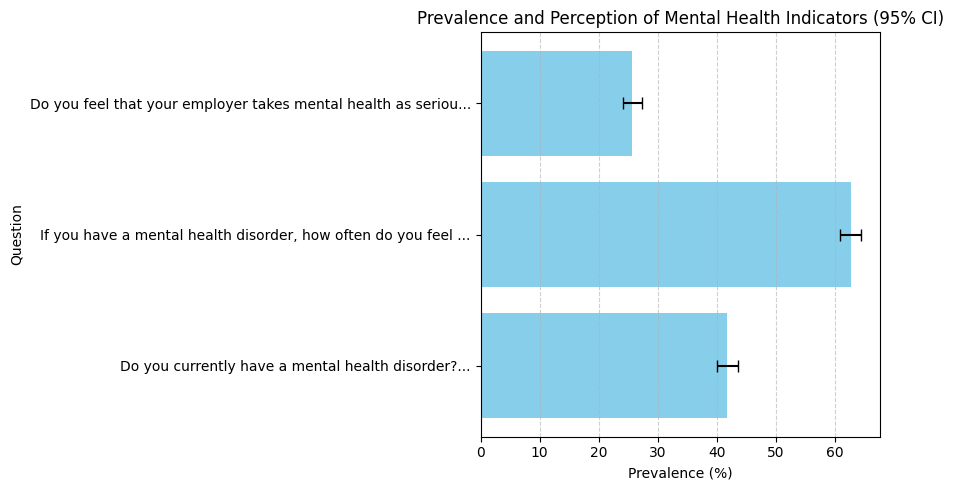

In [20]:
questions = [
    "Do you currently have a mental health disorder?",
    "If you have a mental health disorder, how often do you feel that it interferes with your work when not being treated effectively?",
    "Do you feel that your employer takes mental health as seriously as physical health?"
]

positive_words = ['yes', 'true', 'agree', 'often', 'always', 'sometimes']

ci_results = []

for q in questions:
    subset = df[df['questiontext'].str.contains(q, case=False, na=False)].copy()
    subset['AnswerText'] = subset['AnswerText'].astype(str).str.lower().str.strip()
    
    positive = subset['AnswerText'].apply(lambda x: any(w in x for w in positive_words)).sum()
    n = len(subset)
    if n == 0:
        continue
    
    p_hat = positive / n
    result = stats.binomtest(positive, n, p=p_hat)
    ci_low, ci_high = result.proportion_ci(confidence_level=0.95)
    
    ci_results.append({
        'Question': q[:60] + '...',
        'Prevalence': p_hat * 100,
        'CI_Lower': ci_low * 100,
        'CI_Upper': ci_high * 100
    })

ci_df = pd.DataFrame(ci_results)
print(ci_df.round(2))

plt.figure(figsize=(9, 5))

bars = plt.barh(
    y=ci_df['Question'],
    width=ci_df['Prevalence'],
    color='skyblue',
    edgecolor='none'
)

for i, (y, mean, lower, upper) in enumerate(
    zip(range(len(ci_df)), ci_df['Prevalence'], ci_df['CI_Lower'], ci_df['CI_Upper'])
):
    plt.errorbar(
        x=mean,
        y=y,
        xerr=[[mean - lower], [upper - mean]],
        fmt='none',
        ecolor='black',
        elinewidth=1.5,
        capsize=4
    )

plt.title('Prevalence and Perception of Mental Health Indicators (95% CI)')
plt.xlabel('Prevalence (%)')
plt.ylabel('Question')
plt.grid(axis='x', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

### 6.5 Confidence Intervals for Mental Health Prevalence
**Takeaway:** Around 42% of respondents report currently having a mental health disorder, and 63% indicate that it interferes with their work when untreated. Only 26% believe their employer takes mental health as seriously as physical health.
The narrow 95% confidence intervals confirm that these estimates are statistically reliable. Overall, mental health concerns are prevalent across the tech workforce, yet workplace support and awareness remain comparatively low.

---

## Section 7: Insights and Answers

The analysis of the Mental Health in the Tech Industry dataset revealed several key insights about mental health trends among technology professionals:

**Demographics:**
The majority of respondents are young professionals aged 25-35, predominantly male and mostly based in the United States, especially in major tech hubs like California and Washington. This shows a clear sampling bias, meaning results reflect mainly Western, male developer perspectives.

**Work Roles:**
Most participants are Back-End and Front-End Developers, which emphasizes that the dataset mainly represents technical roles rather than management or design positions.

**Prevalence of Mental Health Conditions:**
Around 42% of respondents reported currently having a mental health disorder, and 63% said it interferes with their work when untreated. These rates highlight a significant presence of mental health challenges across the tech workforce.

**Workplace Support and Attitudes:**
Only 26% of respondents believe their employer treats mental health as seriously as physical health. This indicates a gap in organizational support and awareness.

**Confidence Intervals:**
The narrow 95% confidence intervals for prevalence estimates confirm that these findings are statistically reliable, suggesting that mental health concerns are widespread, not random anomalies.

The exploratory analysis revealed that mental health issues are common among tech professionals, yet employer awareness and support remain limited. The study underscores the need for stronger workplace initiatives, destigmatization and balanced data collection to ensure future analyses better represent the global tech community.

---

## Section 8: Future Improvements

Expand the Dataset:
Include more recent surveys and ensure broader international participation to reduce the current U.S. and male dominated sampling bias.

Correlational and Predictive Analysis:
Investigate relationships between demographics (gender, country, role) and mental health outcomes using correlation matrices or regression models.

---